In [1]:
import json

import bz2
import regex
from tqdm import tqdm
from scipy import sparse

In [3]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [4]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [00:58, 3412.70it/s]


#  Домашнее задание по NLP # 3
## Составление словарей для классификации по тональности
При классификации текстов или предложений по тональности необходимо использовать оценочные словари для предметной области, то есть, такие словари, в которых содержатся отрицательные и позитивные слова для какой-то предметной области. Идея подобных словарей основана на следующих наблюдениях: во-первых, для разных товаров используются разные оценочные слова (например бывает “захватывающая книга”, но не бывает “захватывающих лыж”), во-вторых, в контексте разных товаров одни и те же слова могут иметь разную окраску (слово “тормоз” в отзыве на велосипед имеет нейтральную окраску, в отзыве на компьютер – резко негативную, “пыль” в контексте пылесосов – нейтральную, в контексте кофемолок – положительную (“мелкий помол в пыль”)). Еще один пример: "теплое пиво" – это плохо, а "теплый свитер" – это хорошо.  

Составление таких словарей в ручную – трудоемкий процесс, но, к счастью, его не сложно автоматизировать, если собрать достаточно большие корпуса отзывов. В этом домашнем задании вам предстоит попробовать реализовать один их подходов к составлению оценочных словарей, основанный на статье Inducing Domain-Specific Sentiment Lexicons from Unlabeled Corpora (https://nlp.stanford.edu/pubs/hamilton2016inducing.pdf).


Данные для задания – уже знакомые вам отзывы на банки, собранные с нескольких сайтов Рунета. Отзывы могут быть как положительными (оценка 5), так и отрицательными (оценка 1).

In [6]:
responses[99]

{'city': 'г. Саратов',
 'rating_not_checked': False,
 'title': 'Карта ко вкладу',
 'num_comments': 0,
 'bank_license': 'лицензия № 880',
 'author': 'ronnichka',
 'bank_name': 'Югра',
 'datetime': '2015-06-03 20:56:57',
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'rating_grade': 3}

## Часть 1. Обучение модели word2vec

#### 1. Разбейте всю коллекцию отзывов на предложения. Лемматизируйте все слова. 


In [7]:
df = pd.DataFrame(responses)
df.head(5)

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN


In [8]:
import pymorphy3
m = pymorphy3.MorphAnalyzer()

In [9]:
import re

In [10]:
from nltk.corpus import stopwords

In [11]:
mystopwords = stopwords.words('russian') + [
    'это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д',
    'который','прошлый','сей', 'свой', 'наш', 'мочь', 'такой'
]
ru_words = re.compile("[А-Яа-яЁё]+")


def words_only(text):
    return " ".join(ru_words.findall(text))


def lemmatize(text, mystem=m):
    try:
        return " ".join([m.parse(w)[0].normal_form for w in text.split(' ')]).strip()  
    except:
        return " "

def remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

    
def preprocess(text):
    return remove_stopwords(lemmatize(words_only(text.lower())))

Хочу сбалансировать все отзывы с разными оценками. Буду потихоньку делать, потом датафрейм в один слеплю сбалансированный.

In [12]:
list_of_values = [1]
df_1 = df[df['rating_grade'].isin(list_of_values)][0:500]
df_1.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
19,г. Москва,False,Некомпетентность сотрудников банка,2,лицензия № 1481,agelun,Сбербанк России,2015-06-05 15:00:54,Открыт вклад и счет в USD. Плюс к этому есть з...,1.0
33,г. Ростов-на-Дону,False,Навязывание страховки,1,лицензия № 1481,Joker888,Сбербанк России,2015-06-05 21:35:40,Доброго времени! Вчера мне поступило смс-уведо...,1.0
76,г. Санкт-Петербург,False,Нарушение договора банковского вклада,0,лицензия № 3006,qwarta45,АктивКапитал Банк,2015-06-06 23:42:39,"05.06.2015г. около 15 часов, пришел в указанны...",1.0
85,г. Москва,False,"Невозможно оплатить отчисления на капремонт ""Т...",4,лицензия № 1481,721,Сбербанк России,2015-06-04 13:27:04,Для оплаты коммунальных платежей пользуюсь пла...,1.0
94,г. Чапаевск,False,Некомпетентность сотрудника Сбербанка при пров...,16,лицензия № 1481,usmanovaket,Сбербанк России,2015-06-03 16:00:12,В апреле этого года пришла в отделение сбербан...,1.0


In [13]:
%%time
df_1.text = df_1.text.apply(preprocess)

CPU times: total: 19.5 s
Wall time: 19.8 s


In [14]:
list_of_values = [2]
df_2 = df[df['rating_grade'].isin(list_of_values)][0:500]

In [15]:
%%time
df_2.text = df_2.text.apply(preprocess)

CPU times: total: 18.7 s
Wall time: 18.8 s


In [16]:
list_of_values = [3]
df_3 = df[df['rating_grade'].isin(list_of_values)][0:500]

In [17]:
%%time
df_3.text = df_3.text.apply(preprocess)

CPU times: total: 19 s
Wall time: 19.1 s


In [18]:
list_of_values = [4]
df_4 = df[df['rating_grade'].isin(list_of_values)][0:500]

In [19]:
%%time
df_4.text = df_4.text.apply(preprocess)

CPU times: total: 18.7 s
Wall time: 18.8 s


In [20]:
list_of_values = [5]
df_5 = df[df['rating_grade'].isin(list_of_values)][0:500]

In [21]:
%%time
df_5.text = df_5.text.apply(preprocess)

CPU times: total: 14 s
Wall time: 14.1 s


In [22]:
df_5

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
98,г. Санкт-Петербург,False,"Хорошо, когда проблемы решаются",0,лицензия № 1073,apka45,Русславбанк,2015-06-03 17:40:38,досрочно закрывать вклад отпуск жена заказыват...,5.0
122,г. Нижний Новгород,False,Изменяют проценты по уже открытому договору вк...,3,лицензия № 226,20157673,РосинтерБанк,2015-06-04 09:38:18,хотеть открыть вклад доходный год процент начи...,5.0
157,г. Москва,False,"Отделение Марксистская, дом 5: спасибо за помощь!",0,лицензия № 1623,ospar,ВТБ 24,2015-06-04 22:58:38,вчера июнь просидеть очередь х час получение с...,5.0
259,г. Москва,False,Хорошее обслуживание,0,лицензия № 3206,ser-gyr,Соверен Банк,2015-06-02 18:23:41,сегодня открывать вклад банк очередь клиент за...,5.0
266,г. Москва,False,Моя история получения кредита в Ренессанс Кред...,1,лицензия № 3354,SkaIa,Ренессанс Кредит,2015-06-03 02:03:28,история получение кредит ренессанс кредит банк...,5.0
...,...,...,...,...,...,...,...,...,...,...
10395,г. Салават,False,Спасибо за понимание!,1,лицензия № 316,consul_83,Хоум Кредит Банк,2015-03-11 20:44:00,г обратиться банк хоум кредит банк претензия п...,5.0
10396,г. Санкт-Петербург,False,Получение карты,0,лицензия № 3052,avm1962,Европлан Банк,2015-03-11 20:51:00,заказать дебетовый карта ао европлан банк сайт...,5.0
10434,г. Москва,False,Благодарность,0,лицензия № 1481,ways76,Сбербанк России,2015-03-12 09:57:00,год брать автокредит условие кредит должный де...,5.0
10455,г. Москва,False,Обслуживание,2,лицензия № 1975,marina82,АйМаниБанк,2015-03-12 12:00:00,мнение хороший банк общаться банк около год вр...,5.0


In [23]:
res = pd.concat([df_1, df_2, df_3, df_4, df_5], axis=0) #до этого разделили для баланса классов, теперь 5 датафреймов объединяем в один

In [24]:
len(res) #теперь есть датафрейм с 2000 отзывами, по 500 в каждом классе (с оценками 1, 2, 3, 4)

2500

#### 2. Обучите по коллекции предложений word2vec

данные должны быть итерируемым объектом

size — размер вектора,

window — размер окна наблюдения,

min_count — мин. частотность слова в корпусе,

sg — используемый алгоритм обучения (0 — CBOW, 1 — Skip-gram),

sample — порог для downsampling'a высокочастотных слов,

workers — количество потоков,

alpha — learning rate,

iter — количество итераций,

max_vocab_size — позволяет выставить ограничение по памяти при создании словаря (т.е. если ограничение превышается, то низкочастотные слова будут выбрасываться). Для сравнения: 10 млн слов = 1Гб RAM.

In [25]:
from gensim.models import word2vec

Подготовим данные для word2vec (списки из слов, каждое слово - строка):

In [26]:
res.text

19       открыть вклад счёт плюс зарплатный карта рубль...
33       добрый время вчера поступить смс уведомление б...
76       г около час прийти указанный офис намерение по...
85       оплата коммунальный платёж пользоваться пласти...
94       апрель год прийти отделение сбербанк г чапаевс...
                               ...                        
10395    г обратиться банк хоум кредит банк претензия п...
10396    заказать дебетовый карта ао европлан банк сайт...
10434    год брать автокредит условие кредит должный де...
10455    мнение хороший банк общаться банк около год вр...
10458    год открыть муж просто вклад приятно удивить в...
Name: text, Length: 2500, dtype: object

In [27]:
for_word2vec = []
for row in res.text:
    split_row = row.split(' ')
    for_word2vec.append(split_row)
len(for_word2vec)

2500

In [28]:
print("Training model...")

%time model_en = word2vec.Word2Vec(for_word2vec, workers=4, vector_size=300, min_count=3, window=10, sample=1e-3)

Training model...
CPU times: total: 4.39 s
Wall time: 1.33 s


#### 3. Приведите несколько удачных и неудачных примеров решения стандартных текстов для word2vec:

тест на определение ближайших слов

In [29]:
word = 'идти'

In [30]:
print(model_en.wv.most_similar(word, topn=5)) #думаю, удачно, второе странновато, но объяснимо

[('двигаться', 0.9631497859954834), ('лоток', 0.9623263478279114), ('перерыв', 0.956494927406311), ('занимать', 0.9562496542930603), ('одинаково', 0.954664409160614)]


In [31]:
word = 'модель'

In [32]:
print(model_en.wv.most_similar(word, topn=5)) #а вот тут думаю не особо сложилось, связь наоборот, совместный, честь и глава сложно описать

[('наоборот', 0.9965267181396484), ('совместный', 0.9956444501876831), ('честь', 0.995473325252533), ('глава', 0.9950098991394043), ('ибо', 0.9940296411514282)]


тест на аналогии (мужчина – король : женщина – королева)

In [96]:
print(model_en.wv.most_similar(positive=["женщина", "сотрудник"], negative=["мужчина"], topn=1)) #неудачно

[('отдел', 0.9415647983551025)]


In [98]:
print(model_en.wv.most_similar(positive=["человек", "банк"], negative=["женщина"], topn=1)) #удачно

[('клиент', 0.8172756433486938)]


тест на определение лишнего слова.

In [101]:
print(model_en.wv.doesnt_match("ипотека кредит банк ложь".split())) #неудачно

кредит


In [103]:
print(model_en.wv.doesnt_match("женщина мужчина сотрудник втб".split())) #удачно

втб


#### 3. Постройте несколько визуализаций:

##### TSNE для топ-100 (или топ-500) слов и найдите осмысленные кластеры слов


Сначала найдём самые популярные слова:

In [46]:
for_counter = []
for list_ in for_word2vec:
    for word in list_:
        for_counter.append(word)

In [47]:
#топ-100 слов
from collections import Counter

my_list = for_word2vec
most_common_element = Counter(for_counter).most_common(100)#[0][0]

print(most_common_element[0:10])

[('банк', 11222), ('карта', 5778), ('всё', 3599), ('день', 2853), ('отделение', 2676), ('деньга', 2583), ('сотрудник', 2500), ('клиент', 2467), ('вклад', 2214), ('счёт', 2178)]


#### t-SNE
t-SNE (t-distributed Stochastic Neighbor Embedding) — техника нелинейного снижения размерности и визуализации многомерных переменных. Она разработана специально для данных высокой размерности Л. ван дер Маатеном и Д. Хинтоном. 

t-SNE — это итеративный алгоритм, основанный на вычислении попарных расстояний между всеми объектами (в том числе поэтому он довольно медленный).

In [48]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [49]:
for i in most_common_element[0:5]: #добираемся до слов
    print(i[0])

банк
карта
всё
день
отделение


In [50]:
most_common_words = {} #делаем словарик где ключ - слово, значение - его координаты
just_vectors = []
for i in most_common_element:
    vector = model_en.wv[i[0]]
    just_vectors.append(vector)
    most_common_words[i[0]] = vector
    
#print(most_common_words)

In [51]:
#vectors = TfidfVectorizer().fit_transform(df_1.text) # строим тф-идф матрицу документ-слово, сейчас не надо, у нас уже вектора есть
X_reduced = TruncatedSVD(n_components=5, random_state=0).fit_transform(just_vectors) # оставляем n главных компонент, в данном случае 2, т.к изображение
#будет двумерным

In [52]:
# %%time
X_embedded = TSNE(n_components=2, perplexity=5, verbose=0).fit_transform(X_reduced) # строим мэппинг в двухмерную плоскость с TSNE

In [53]:
vis_df = pd.DataFrame({'X': X_embedded[:, 0], 'Y': X_embedded[:, 1], 'text' : most_common_words.keys()}) #создаём датафрейм чтоб удобнее было график строить

In [54]:
vis_df

,X,Y,text
0,-3.007504,-10.500837,банк
1,-40.291344,-7.787214,карта
2,10.534598,-3.356484,всё
3,0.274740,20.642555,день
4,21.611078,-10.479396,отделение
...,...,...,...
95,-40.780750,-17.556438,руб
96,12.187049,-26.121037,специалист
97,24.142441,17.338907,претензия
98,10.806231,20.273348,ответить


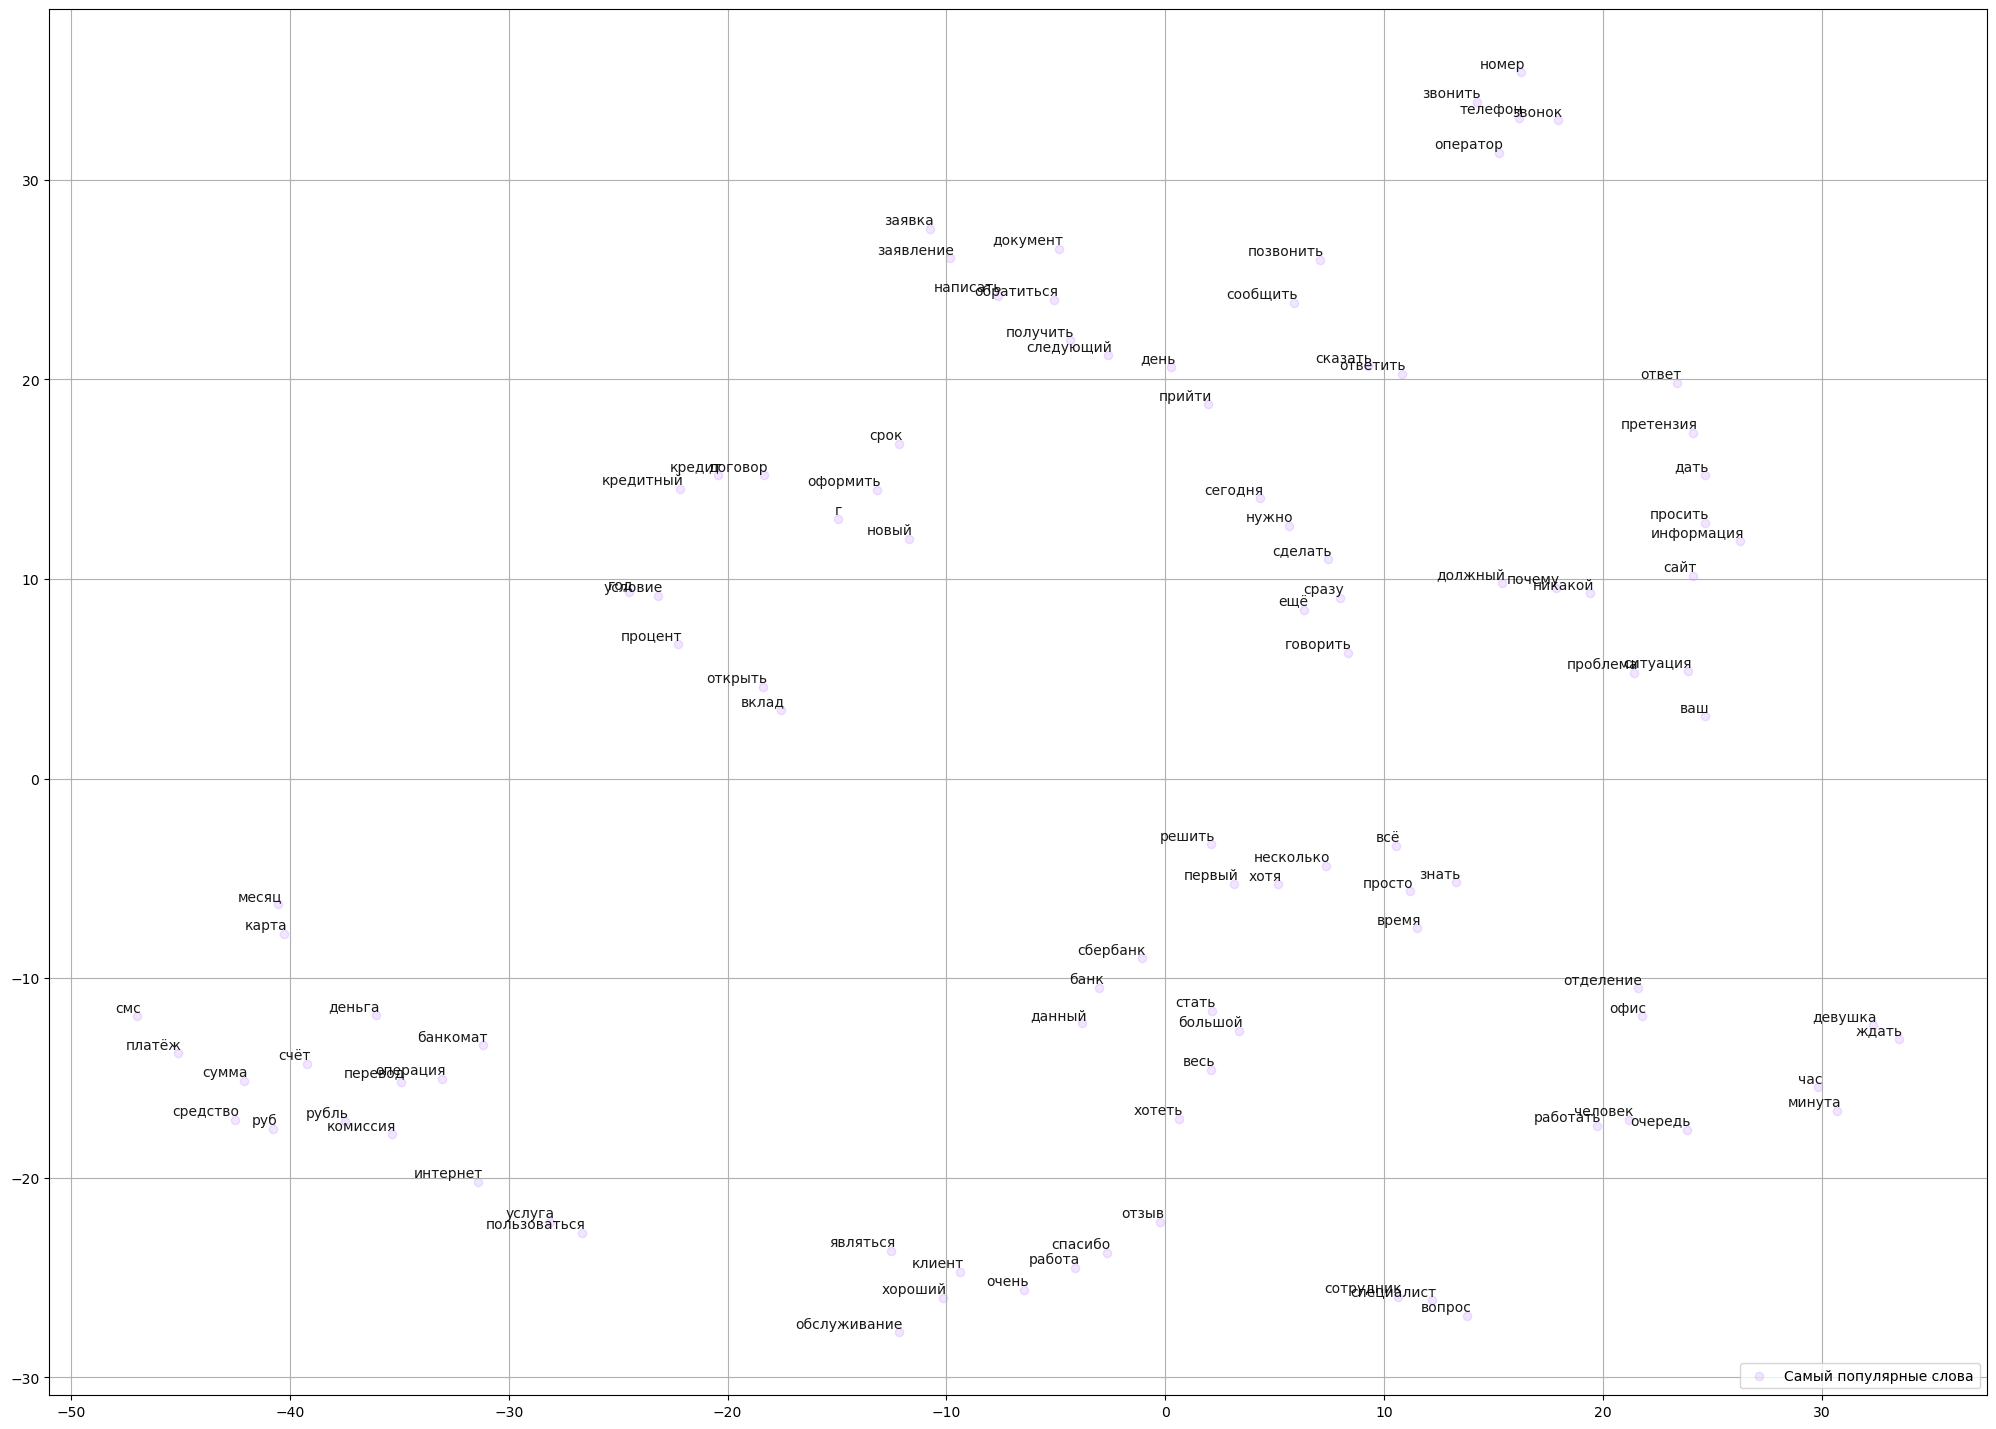

In [105]:
def tsne_plot_2d(label, embeddings, words, a=1):
    plt.figure(figsize=(25, 18))
    colors = cm.rainbow(np.linspace(0, 1, 1))
    x = vis_df.X
    y = vis_df.Y
    plt.scatter(x, y, c=colors, alpha=a, label=label)
    for i, word in enumerate(words):
        plt.annotate(word, alpha=0.9, xy=(x[i], y[i]), xytext=(3, 1), 
                     textcoords='offset points', ha='right', va='bottom', size=10)
    plt.legend(loc=4)
    plt.grid(True)
    plt.savefig("hhh.png", format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_2d('Самый популярные слова', X_embedded, vis_df.text, a=0.1)

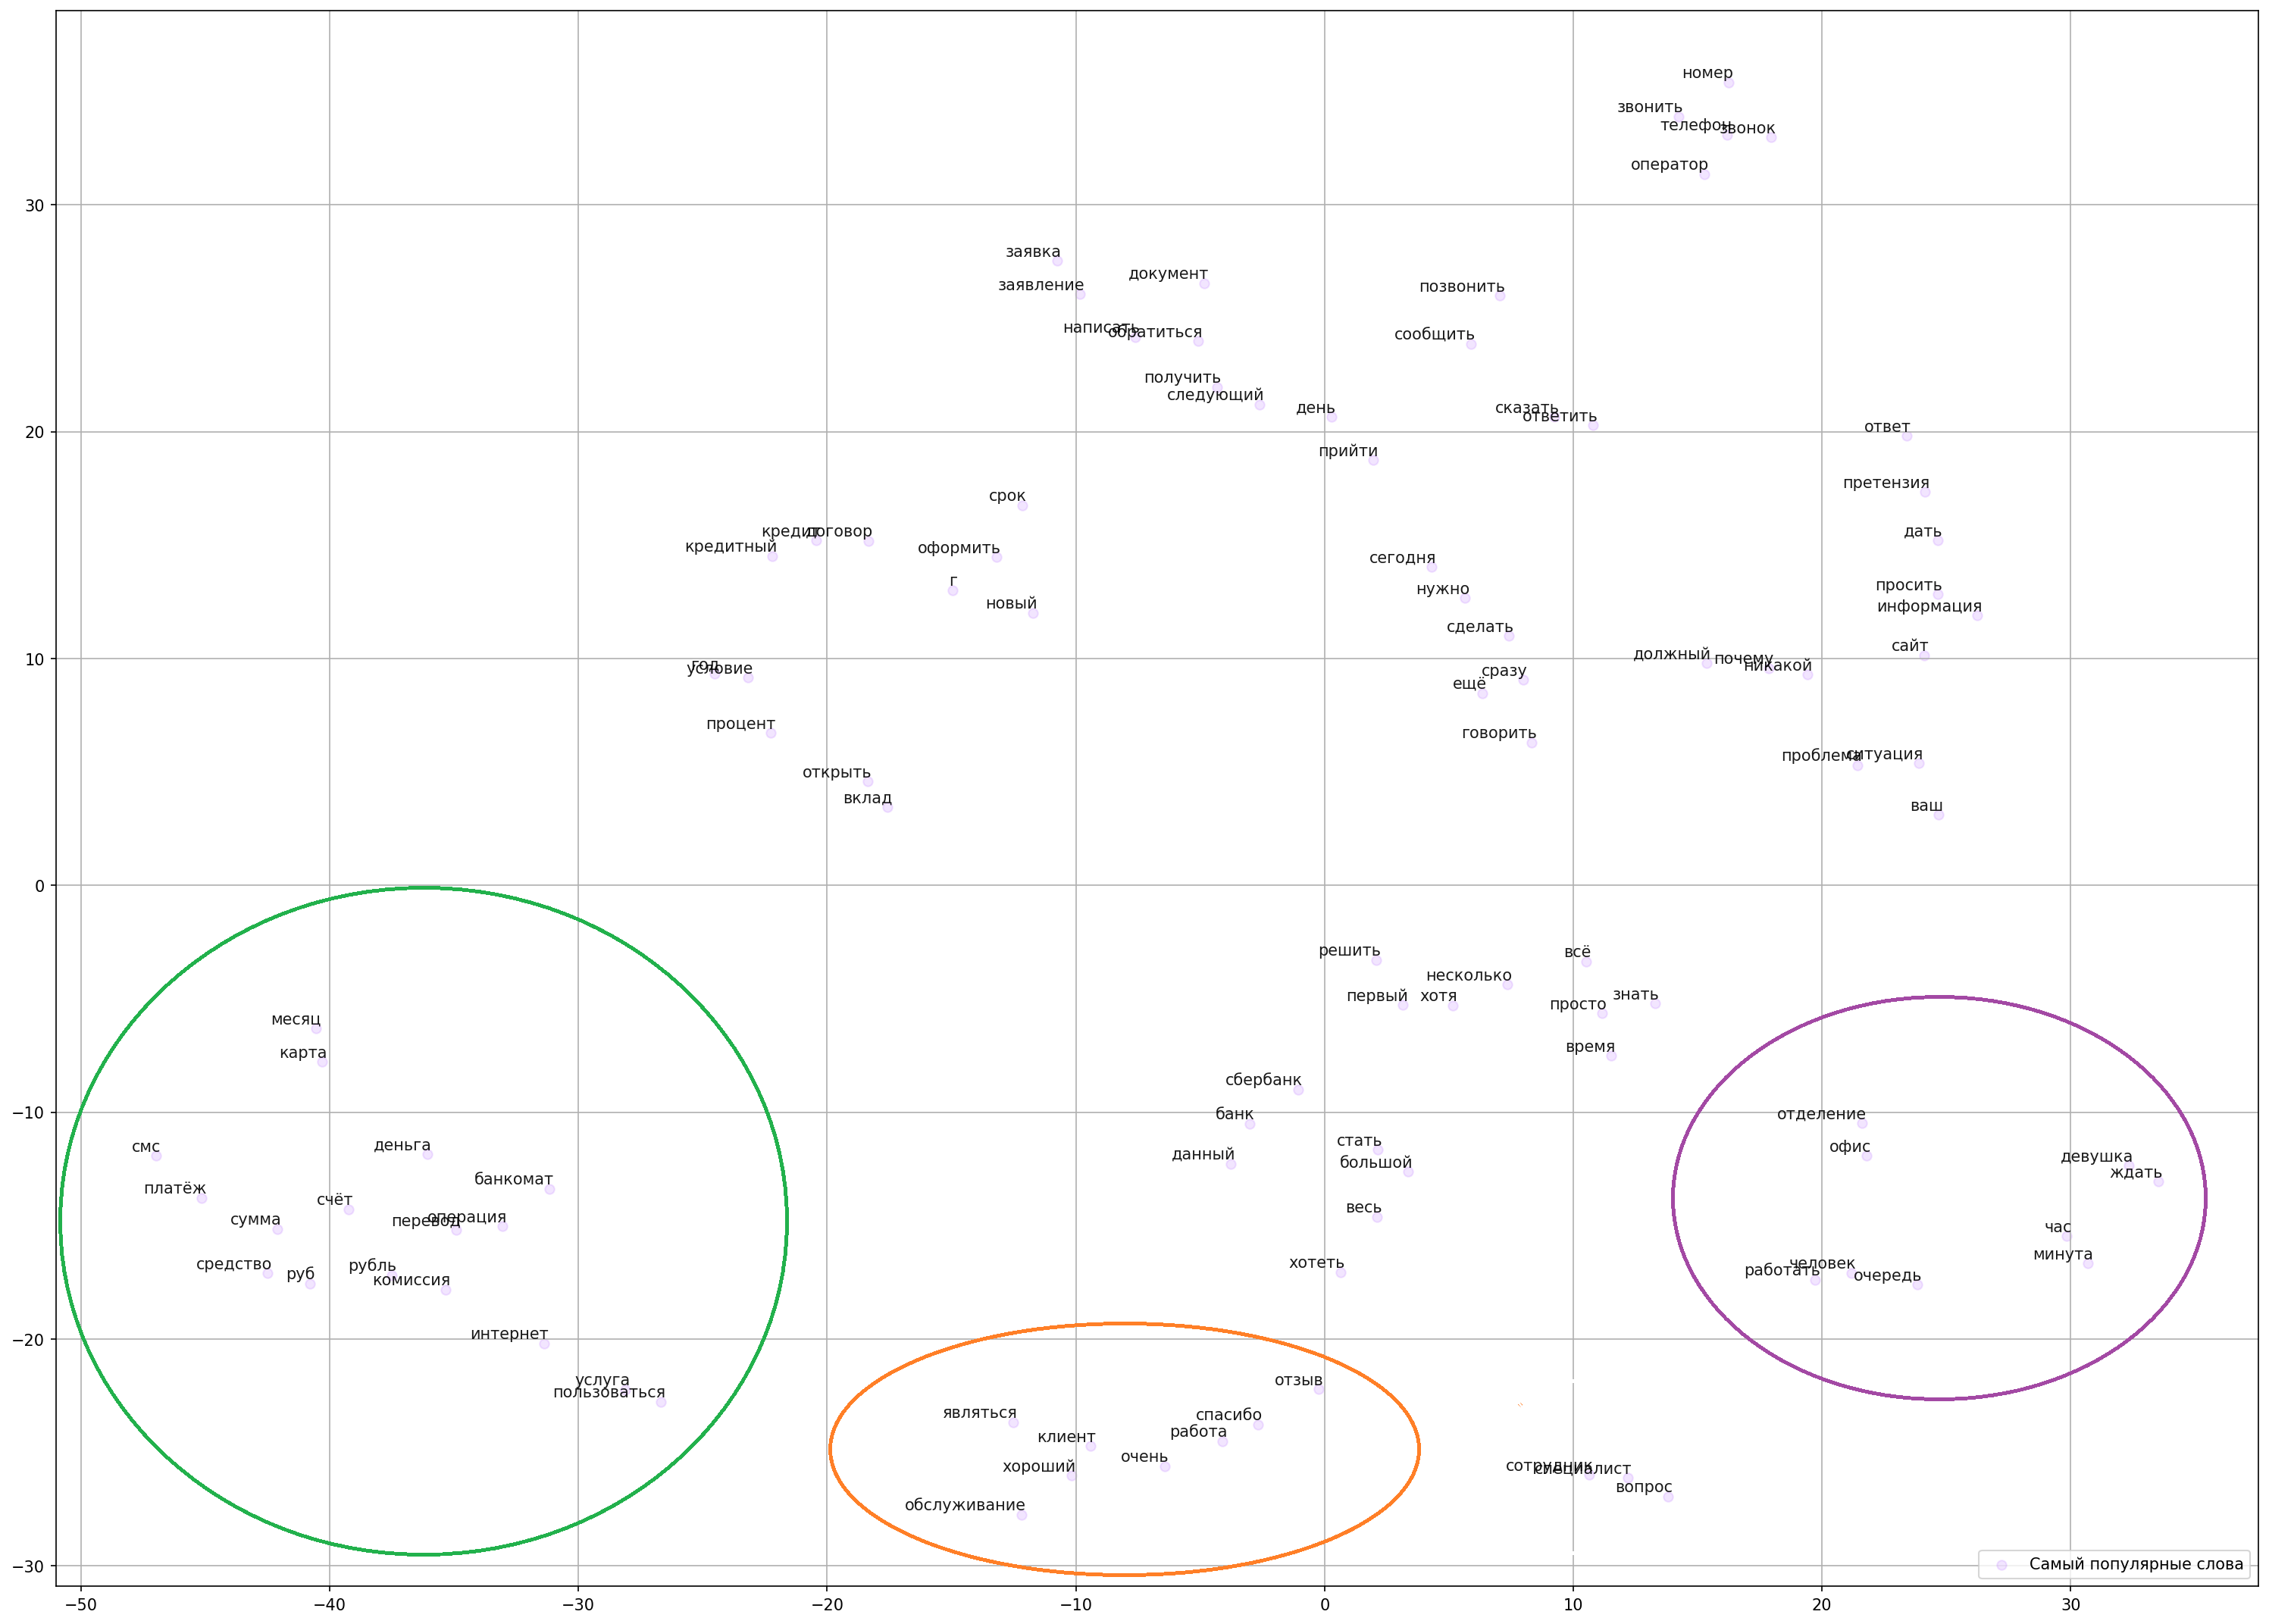

In [109]:
from IPython.display import Image, display

display(Image('clusters1.png', width=600))

Можно заметить кластер, связанный с ожиданием и очередями (обведён фиолетовым), там слова отделение, ждать, час, минута.
Второй кластер (зелёный) связан с переводом и взаимодействием с деньгами, обведён зелёным. Слова операция, комиссия, сумма, платёж.
Третий маленький кластер (оранжевый) явно связан с положительными отзывами, это хороший, спасибо, отзыв.

##### Задайте координаты для нового пространства следующим образом: одна  ось описывает отношение "плохо – хорошо", вторая – "медленно – быстро" и найдите координаты названий банков в этих координатах.  Более формально:

    берем вектор слова "хорошо", вычитаем из него вектор слова "плохо", получаем новый вектор, который описывает разницу между хорошими и плохими словами. Берем вектор слова "сбербанк" и умножаем его на этот новый вектор – получаем координату по первой оси. Аналогично – для второй оси. Две координаты уже можно нарисовать на плоскости.  

In [112]:
#для начала получим сами вектора слов "хорошо" и "плохо" и "сбербанк"
vec_sber = model_en.wv['сбербанк']
vec_good = model_en.wv['хороший']
vec_bad = model_en.wv['плохой']

In [114]:
#вычитаем плохо из хорошо, получаем разницу плохих и хороших слов
difference_grade = vec_good - vec_bad

In [116]:
#берём вектор слова сбербанк и умножаем на разницу
X_sber = vec_sber*difference_grade #здесь получился достаточно длинный вектор, но нам нужно одно значение для координаты

In [118]:
X_sber = X_sber.mean()#класс, получили координату по одной оси для сбербанка
X_sber

0.00456853

In [120]:
vec_slow = model_en.wv['медленно']
vec_fast = model_en.wv['быстро']

In [122]:
difference_speed = vec_fast - vec_slow

In [124]:
Y_sber = vec_sber*difference_speed

In [126]:
Y_sber = Y_sber.mean()
Y_sber

-0.0044718497

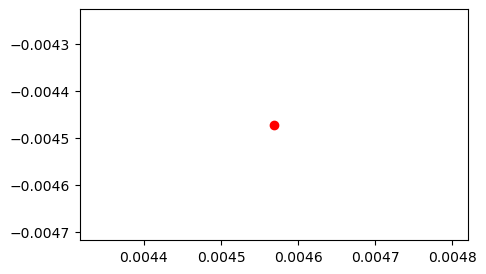

In [128]:
#ну раз я начала всё для одного значения подробно делать, нанесу это одно значение на график. далее сделаем нормально функцией для остальных банков
fig, ax = plt.subplots()
fig.set_size_inches(5,3)
plt.plot(X_sber, Y_sber, 'ro')
plt.show()

In [130]:
#посмотрим количество банков и возьмём 15 самых популярных для визуализации
len(unique(df_1.bank_name))

69

In [132]:
most_popular_banks = df_1['bank_name'].value_counts()[0:15]
most_popular_banks[0:15]

bank_name
Сбербанк России                   135
ВТБ 24                             49
Альфа-Банк                         30
ОТП Банк                           19
Хоум Кредит Банк                   19
Русский Стандарт                   18
ОПМ-Банк                           14
Национальный Банк «Траст»          14
Московский Кредитный Банк          14
Промсвязьбанк                      12
Восточный Экспресс Банк            10
Ханты-Мансийский банк Открытие     10
Банк Москвы                        10
Метробанк                           9
Росбанк                             7
Name: count, dtype: int64

In [134]:
most_popular_banks = most_popular_banks.index.to_list() #переведём названия банков в список чтобы с ними проще дальше было работать
most_popular_banks

['Сбербанк России',
 'ВТБ 24',
 'Альфа-Банк',
 'ОТП Банк',
 'Хоум Кредит Банк',
 'Русский Стандарт',
 'ОПМ-Банк',
 'Национальный Банк «Траст»',
 'Московский Кредитный Банк',
 'Промсвязьбанк',
 'Восточный Экспресс Банк',
 'Ханты-Мансийский банк Открытие',
 'Банк Москвы',
 'Метробанк',
 'Росбанк']

In [148]:
#чуть обработаем, чтобы названия всех банков из одного слова состояли, так как в модели то у нас вектора слов, а не словосочетаний
#я могла бы разделить по пробелам и откинуть второе слово, но для 10 названий легче обрабаотывать вручную. А русский стандарт и кредитный
#банк вообще выкинем, непонятно какое слово брать, русский или стандарт
most_popular_banks = [
    'сбербанк',
 'втб',
 'альфа',
 'отп',
 'хоум',
 'опм',
 'траст',
 'промсвязьбанк',
 'открытие',
 'метробанк']

In [150]:
#далее нужна функция, которая будет проходить по названиям банков, извлекать их вектор, перемножать с плохим хорошим быстрым
#медленным, брать среднее значение получившегося вектора и добавлять его в финальный список для нанесения на график
def funny_task(banks, difference_grade, difference_speed, model_en = model_en):
    X = []
    Y = []
    for bank in banks:
        vec_bank = model_en.wv[bank]
        difference_g = vec_bank*difference_grade
        difference_s = vec_bank*difference_speed
        X.append(difference_g.mean())
        Y.append(difference_s.mean())
    return X, Y
#названия банков возьму из most_popular_banks

In [152]:
X, Y = funny_task(most_popular_banks, difference_grade, difference_speed)

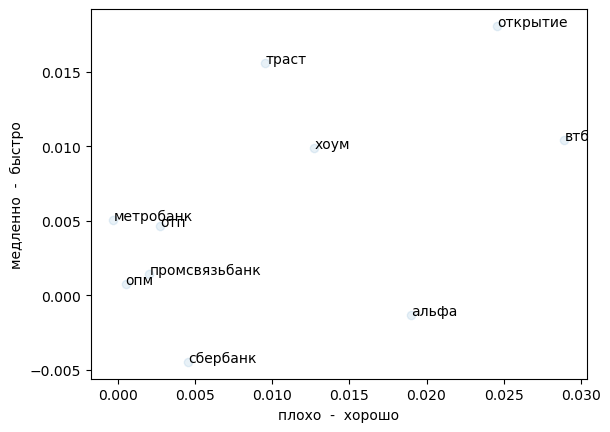

In [158]:
labels = most_popular_banks # Метки точек

plt.scatter(X, Y, alpha=0.1)  # Создаем точечный график
# Добавляем текстовые метки к каждой точке
for x_coord, y_coord, label in zip(X, Y, labels):
    plt.text(x_coord, y_coord, label,
             fontsize=10, color='black', ha='left')
plt.xlabel("плохо  -  хорошо")
plt.ylabel("медленно  -  быстро")

plt.show()

## Часть 2. Распространение метки

Определите 5-8 позитивных слов (например, “быстрый”, “удобный”) и 5-8  негативных слов (например,“очередь”, “медленно”). Эти слова будут основной будущего оценочного словаря. Пусть позитивному классу соответствует метка 1, негативному – -1. Пометьте выбранные слова в лексическом графе соответствующими метками. Запустите любой известный вам метод распространения метки (Label Propogation) в лексическом графе. На выходе метода распространения ошибки должны быть новые слова, помеченные метками 1 и -1 – это и есть искомые оценочные слова.

Алгоритмы распространения метки устроены примерно так: пусть мы находимся в выршине, помеченном +1. С какой-то вероятностью мы переносим эту метку на соседние узлы. С меньшей вероятностью переносим ее на вершины на расстоянии два. В конце распространения метки, часть вершин оказывается помечена меткой +1, часть – -1, большая часть остается без метки.

Рекомендуемые алгоритмы распространения метки:
1. ```graphlab.label_propagation``` (```graphlab``` доступен бесплатно по образовательной лицензии)
2. ```sklearn.semi_supervised.LabelPropagation``` 
3. ```sklearn.semi_supervised.LabelSpreading```

##### 2.1 Определите 5–8 позитивных слов (например, быстрый, удобный) и 5–8 негативных слов (например, очередь, медленно).
Эти слова будут основной будущего оценочного словаря

In [160]:
#Определяем слова, смотрим, что они есть в словаре.
good_words = ['хороший', 'отличный', 'удобно', 'быстро', 'здорово']
good_vectors = []
for word in good_words:
    vec_slow = model_en.wv[word]
    good_vectors.append(vec_slow)
len(good_vectors)

5

In [162]:
bad_words = ['плохой', 'медленный', 'неудобный', 'очередь', 'сбой']
bad_vectors = []
for word in bad_words:
    vec_slow = model_en.wv[word]
    bad_vectors.append(vec_slow)
len(bad_vectors)

5

##### 2.2 Пусть позитивному классу соответствует метка 1, негативному – -1. Пометьте выбранные слова в лексическом графе соответствующими метками.

In [288]:
# пример построения графа 
model = model_en
words = list(model.wv.index_to_key)
import igraph as ig
g = ig.Graph(directed=True)
for word in words:
    g.add_vertex(word)
    
for word in words :
    node = g.vs.select(name = word).indices[0]
    similar_words = model.wv.most_similar(word, topn=5)
    for sim in similar_words:
        word1 = sim[0]
        val  = sim[1]
        new_node = g.vs.select(name = word1).indices[0]
        g.add_edge(node, new_node, weight = val)

In [289]:
print(g) #выводим получившийся граф

IGRAPH DNW- 7047 35235 --
+ attr: name (v), weight (e)
+ edges (vertex names):
                    банк -> данный, здравствуйте, столкнуться, хкб, обучать
                   карта -> дебетовый, выпустить, выпуск, именной, истекший
                     всё -> ещё, думать, таки, долго, автопролонгация
                    день -> следующий, неделя, течение, календарный,
прошествие
               отделение -> офис, далее, находиться, ленинский, проспа
                  деньга -> снять, перевести, чек, положить, распознать
               сотрудник -> помочь, руководитель, отдел, общаться, книга
                  клиент -> хороший, отношение, впечатление, целое, уделять
                   вклад -> открыть, открытие, депозит, открывать, двухлетний
                    счёт -> перевод, снятие, перевести, текущий, австралийский
                  кредит -> страховка, погасить, потребительский, досрочно,
одобрять
                     год -> назад, зарплатный, держатель, прошлое, уволиться
        

In [298]:
g.add_vertices(3)

In [300]:
g.add_edges([(0,1), (1,2)])

In [302]:
g = ig.Graph.GRG(100, 0.2)
ig.summary(g)

IGRAPH U--- 100 563 -- 
+ attr: x (v), y (v)


In [310]:
node_df

,x,y
0,0.000023,0.279082
1,0.024495,0.484987
2,0.028363,0.972672
3,0.042453,0.675477
4,0.050696,0.856007
...,...,...
95,0.859835,0.016135
96,0.906694,0.144542
97,0.938648,0.037949
98,0.973861,0.569342


In [304]:
node_df = pd.DataFrame({attr: g.vs[attr] for attr in g.vertex_attributes()}) #источник https://igraph.discourse.group/t/convert-graph-object-to-dataframe/575/5
edge_df = pd.DataFrame({attr: g.es[attr] for attr in g.edge_attributes()})

In [312]:
edge_df

""


In [320]:
df = nx.to_pandas_edgelist(g)
df

AttributeError: 'Graph' object has no attribute 'edges'

In [264]:
g = ig.Graph([(0,1), (0,2), (2,3), (3,4), (4,2), (2,5), (5,0), (6,3), (5,6)])

In [266]:
g.vs["name"] = ["Alice", "Bob", "Claire", "Dennis", "Esther", "Frank", "George"]
g.vs["age"] = [25, 31, 18, 47, 22, 23, 50]
g.vs["gender"] = ["f", "m", "f", "m", "f", "m", "m"]
g.es["is_formal"] = [False, False, True, True, True, False, True, False, False]

In [270]:
print(g)

IGRAPH UN-- 7 9 --
+ attr: age (v), gender (v), name (v), is_formal (e)
+ edges (vertex names):
 Alice -- Bob, Claire, Frank             Esther -- Claire, Dennis
   Bob -- Alice                           Frank -- Alice, Claire, George
Claire -- Alice, Dennis, Esther, Frank   George -- Dennis, Frank
Dennis -- Claire, Esther, George


In [272]:
g.vertex_attributes() #последовательность вершин

['name', 'age', 'gender']

In [274]:
g.edge_attributes() #последовательность рёбер

['is_formal']

In [278]:
df = g.get_vertex_dataframe()
df.set_index( 'name' , inplace= True )

In [280]:
df

,age,gender
name,,
Alice,25,f
Bob,31,m
Claire,18,f
Dennis,47,m
Esther,22,f
Frank,23,m
George,50,m


In [282]:
node_df = pd.DataFrame({attr: g.vs[attr] for attr in g.vertex_attributes()}) #источник https://igraph.discourse.group/t/convert-graph-object-to-dataframe/575/5
edge_df = pd.DataFrame({attr: g.es[attr] for attr in g.edge_attributes()})

In [284]:
node_df

,name,age,gender
0,Alice,25,f
1,Bob,31,m
2,Claire,18,f
3,Dennis,47,m
4,Esther,22,f
5,Frank,23,m
6,George,50,m


In [286]:
edge_df

,is_formal
0,False
1,False
2,True
3,True
4,True
5,False
6,True
7,False
8,False


In [214]:
from networkx import to_pandas_dataframe

ImportError: cannot import name 'to_pandas_dataframe' from 'networkx' (C:\Users\ksurashanti\anaconda3\Lib\site-packages\networkx\__init__.py)

In [208]:
import networkx as nx

In [202]:
nx.to_pandas_dataframe(g, nodelist=None , multigraph_weight=sum, weight='weight' , nonedge=0.0 )

AttributeError: module 'networkx' has no attribute 'to_pandas_dataframe'